In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = ResNet50(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 3144 samples, validate on 787 samples
Epoch 1/100
3144/3144 [==============================] - 76s 24ms/step - loss: 0.6470 - acc: 0.8645 - val_loss: 1.3344 - val_acc: 0.7408
Epoch 2/100
3144/3144 [==============================] - 72s 23ms/step - loss: 0.2470 - acc: 0.9109 - val_loss: 0.4831 - val_acc: 0.9123
Epoch 3/100
3144/3144 [==============================] - 71s 23ms/step - loss: 0.2925 - acc: 0.9198 - val_loss: 0.7194 - val_acc: 0.7624
Epoch 4/100
3144/3144 [==============================] - 72s 23ms/step - loss: 0.3468 - acc: 0.8880 - val_loss: 3.9424 - val_acc: 0.6607
Epoch 5/100
3144/3144 [==============================] - 71s 22ms/step - loss: 0.2206 - acc: 0.9278 - val_loss: 0.2192 - val_acc: 0.9377
Epoch 6/100
3144/3144 [==============================] - 72s 23ms/step - loss: 0.1933 - acc: 0.9275 - val_loss: 0.2011 - val_acc: 0.9327
Epoch 7/100
3144/3144 [==============================] - 71s 23ms/step - loss: 0.2163 - acc: 0.9348 - val_loss: 1.1767 - val_acc: 0

3144/3144 [==============================] - 72s 23ms/step - loss: 0.0135 - acc: 0.9959 - val_loss: 0.2865 - val_acc: 0.9454
Epoch 61/100
3144/3144 [==============================] - 71s 23ms/step - loss: 0.0226 - acc: 0.9927 - val_loss: 0.3293 - val_acc: 0.9314
Epoch 62/100
3144/3144 [==============================] - 70s 22ms/step - loss: 0.0433 - acc: 0.9844 - val_loss: 0.3924 - val_acc: 0.9250
Epoch 63/100
3144/3144 [==============================] - 71s 22ms/step - loss: 0.0206 - acc: 0.9930 - val_loss: 0.8190 - val_acc: 0.8628
Epoch 64/100
3144/3144 [==============================] - 71s 23ms/step - loss: 0.0518 - acc: 0.9822 - val_loss: 0.4024 - val_acc: 0.9174
Epoch 65/100
3144/3144 [==============================] - 70s 22ms/step - loss: 0.0551 - acc: 0.9812 - val_loss: 0.2591 - val_acc: 0.9365
Epoch 66/100
3144/3144 [==============================] - 74s 23ms/step - loss: 0.0266 - acc: 0.9911 - val_loss: 0.3812 - val_acc: 0.9199
Epoch 67/100
3144/3144 [=======================

3145/3145 [==============================] - 72s 23ms/step - loss: 0.2498 - acc: 0.9335 - val_loss: 0.2811 - val_acc: 0.9071
Epoch 19/100
3145/3145 [==============================] - 71s 22ms/step - loss: 0.1872 - acc: 0.9386 - val_loss: 0.2287 - val_acc: 0.9160
Epoch 20/100
3145/3145 [==============================] - 72s 23ms/step - loss: 0.1649 - acc: 0.9428 - val_loss: 0.3453 - val_acc: 0.9148
Epoch 21/100
3145/3145 [==============================] - 72s 23ms/step - loss: 0.1520 - acc: 0.9482 - val_loss: 0.2609 - val_acc: 0.9427
Epoch 22/100
3145/3145 [==============================] - 70s 22ms/step - loss: 0.1277 - acc: 0.9526 - val_loss: 0.4325 - val_acc: 0.8842
Epoch 23/100
3145/3145 [==============================] - 72s 23ms/step - loss: 0.1219 - acc: 0.9603 - val_loss: 0.3478 - val_acc: 0.8969
Epoch 24/100
3145/3145 [==============================] - 71s 23ms/step - loss: 0.1065 - acc: 0.9641 - val_loss: 0.2566 - val_acc: 0.9389
Epoch 25/100
3145/3145 [=======================

3145/3145 [==============================] - 67s 21ms/step - loss: 0.0226 - acc: 0.9924 - val_loss: 0.2472 - val_acc: 0.9504
Epoch 78/100
3145/3145 [==============================] - 66s 21ms/step - loss: 0.0136 - acc: 0.9959 - val_loss: 0.3045 - val_acc: 0.9491
Epoch 79/100
3145/3145 [==============================] - 66s 21ms/step - loss: 0.0030 - acc: 0.9990 - val_loss: 0.2867 - val_acc: 0.9491
Epoch 80/100
3145/3145 [==============================] - 64s 21ms/step - loss: 0.0042 - acc: 0.9990 - val_loss: 0.3082 - val_acc: 0.9453
Epoch 81/100
3145/3145 [==============================] - 64s 20ms/step - loss: 0.0169 - acc: 0.9959 - val_loss: 0.5253 - val_acc: 0.8410
Epoch 82/100
3145/3145 [==============================] - 65s 21ms/step - loss: 0.0114 - acc: 0.9955 - val_loss: 0.3277 - val_acc: 0.9440
Epoch 83/100
3145/3145 [==============================] - 67s 21ms/step - loss: 0.0183 - acc: 0.9952 - val_loss: 0.3101 - val_acc: 0.9402
Epoch 84/100
3145/3145 [=======================

3145/3145 [==============================] - 66s 21ms/step - loss: 0.1633 - acc: 0.9520 - val_loss: 0.7611 - val_acc: 0.9097
Epoch 36/100
3145/3145 [==============================] - 67s 21ms/step - loss: 0.1946 - acc: 0.9415 - val_loss: 1.2170 - val_acc: 0.8779
Epoch 37/100
3145/3145 [==============================] - 64s 20ms/step - loss: 0.6008 - acc: 0.8712 - val_loss: 6.0203 - val_acc: 0.5293
Epoch 38/100
3145/3145 [==============================] - 66s 21ms/step - loss: 0.3450 - acc: 0.9043 - val_loss: 0.4778 - val_acc: 0.6628
Epoch 39/100
3145/3145 [==============================] - 65s 21ms/step - loss: 0.1850 - acc: 0.9329 - val_loss: 0.1722 - val_acc: 0.9453
Epoch 40/100
3145/3145 [==============================] - 65s 21ms/step - loss: 0.1676 - acc: 0.9402 - val_loss: 0.1575 - val_acc: 0.9529
Epoch 41/100
3145/3145 [==============================] - 66s 21ms/step - loss: 0.1452 - acc: 0.9504 - val_loss: 0.2737 - val_acc: 0.8957
Epoch 42/100
3145/3145 [=======================

3145/3145 [==============================] - 68s 22ms/step - loss: 0.0226 - acc: 0.9927 - val_loss: 0.1341 - val_acc: 0.9707
Epoch 95/100
3145/3145 [==============================] - 66s 21ms/step - loss: 0.0465 - acc: 0.9841 - val_loss: 0.1040 - val_acc: 0.9707
Epoch 96/100
3145/3145 [==============================] - 67s 21ms/step - loss: 0.0147 - acc: 0.9952 - val_loss: 0.1040 - val_acc: 0.9720
Epoch 97/100
3145/3145 [==============================] - 66s 21ms/step - loss: 0.0070 - acc: 0.9978 - val_loss: 0.1216 - val_acc: 0.9669
Epoch 98/100
3145/3145 [==============================] - 65s 21ms/step - loss: 0.0210 - acc: 0.9914 - val_loss: 0.1899 - val_acc: 0.9669
Epoch 99/100
3145/3145 [==============================] - 69s 22ms/step - loss: 0.0210 - acc: 0.9936 - val_loss: 0.2688 - val_acc: 0.9186
Epoch 100/100
786/786 [==============================] - 7s 9ms/step
[2] Test acurracy: 0.9555 (6561.1729 s)
Train on 3145 samples, validate on 786 samples
Epoch 1/100
3145/3145 [======

3145/3145 [==============================] - 72s 23ms/step - loss: 0.2893 - acc: 0.9590 - val_loss: 0.4832 - val_acc: 0.9249
Epoch 53/100
3145/3145 [==============================] - 71s 23ms/step - loss: 0.2338 - acc: 0.9647 - val_loss: 1.5259 - val_acc: 0.6336
Epoch 54/100
3145/3145 [==============================] - 70s 22ms/step - loss: 0.2543 - acc: 0.9269 - val_loss: 0.5405 - val_acc: 0.8448
Epoch 55/100
3145/3145 [==============================] - 72s 23ms/step - loss: 0.1288 - acc: 0.9615 - val_loss: 0.2348 - val_acc: 0.9402
Epoch 56/100
3145/3145 [==============================] - 71s 23ms/step - loss: 0.1982 - acc: 0.9507 - val_loss: 3.7426 - val_acc: 0.7265
Epoch 57/100
3145/3145 [==============================] - 71s 22ms/step - loss: 0.1680 - acc: 0.9507 - val_loss: 0.3775 - val_acc: 0.8944
Epoch 58/100
3145/3145 [==============================] - 71s 23ms/step - loss: 0.1894 - acc: 0.9634 - val_loss: 0.3061 - val_acc: 0.9020
Epoch 59/100
3145/3145 [=======================

3145/3145 [==============================] - 70s 22ms/step - loss: 0.2128 - acc: 0.9355 - val_loss: 0.1798 - val_acc: 0.9427
Epoch 11/100
3145/3145 [==============================] - 70s 22ms/step - loss: 0.1742 - acc: 0.9498 - val_loss: 0.1794 - val_acc: 0.9415
Epoch 12/100
3145/3145 [==============================] - 72s 23ms/step - loss: 0.1754 - acc: 0.9514 - val_loss: 0.1911 - val_acc: 0.9198
Epoch 13/100
3145/3145 [==============================] - 73s 23ms/step - loss: 0.1559 - acc: 0.9501 - val_loss: 0.2268 - val_acc: 0.9402
Epoch 14/100
3145/3145 [==============================] - 72s 23ms/step - loss: 0.1604 - acc: 0.9491 - val_loss: 0.2399 - val_acc: 0.9008
Epoch 15/100
3145/3145 [==============================] - 69s 22ms/step - loss: 0.4521 - acc: 0.8897 - val_loss: 1.3020 - val_acc: 0.5000
Epoch 16/100
3145/3145 [==============================] - 67s 21ms/step - loss: 0.5954 - acc: 0.8897 - val_loss: 2.6194 - val_acc: 0.5840
Epoch 17/100
3145/3145 [=======================

3145/3145 [==============================] - 72s 23ms/step - loss: 0.0436 - acc: 0.9870 - val_loss: 0.2005 - val_acc: 0.9466
Epoch 70/100
3145/3145 [==============================] - 69s 22ms/step - loss: 0.0723 - acc: 0.9755 - val_loss: 0.1259 - val_acc: 0.9504
Epoch 71/100
3145/3145 [==============================] - 65s 21ms/step - loss: 0.0422 - acc: 0.9873 - val_loss: 0.2876 - val_acc: 0.9008
Epoch 72/100
3145/3145 [==============================] - 70s 22ms/step - loss: 0.0310 - acc: 0.9901 - val_loss: 0.1187 - val_acc: 0.9593
Epoch 73/100
3145/3145 [==============================] - 72s 23ms/step - loss: 0.0493 - acc: 0.9838 - val_loss: 0.1161 - val_acc: 0.9644
Epoch 74/100
3145/3145 [==============================] - 71s 23ms/step - loss: 0.0549 - acc: 0.9822 - val_loss: 0.1254 - val_acc: 0.9606
Epoch 75/100
3145/3145 [==============================] - 70s 22ms/step - loss: 0.0418 - acc: 0.9841 - val_loss: 0.1300 - val_acc: 0.9555
Epoch 76/100
3145/3145 [=======================

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9400


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

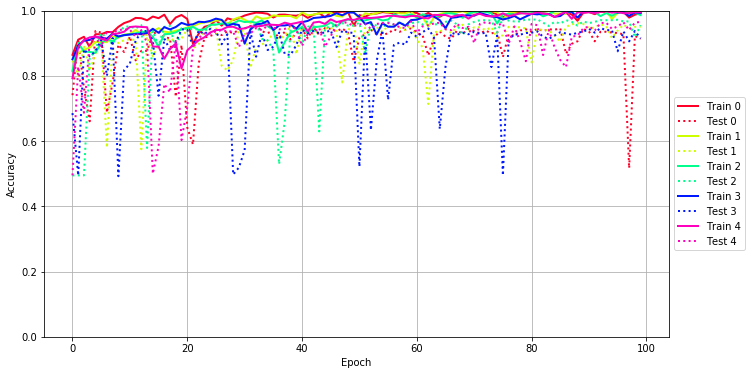

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

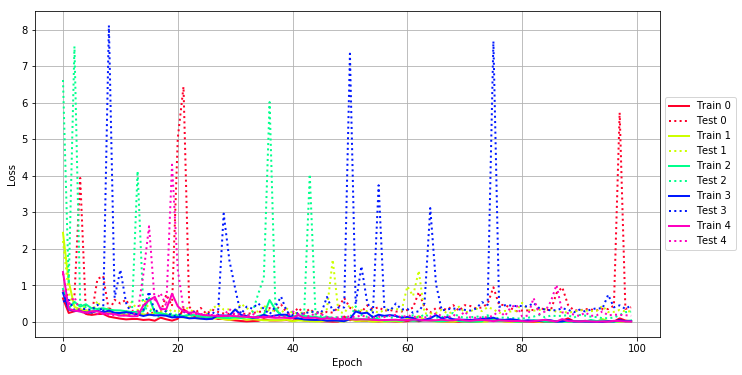

In [12]:
plot_loss(history)

Plotting the confusion matrix


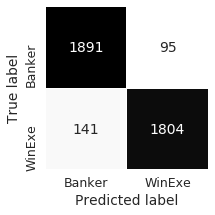

In [13]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


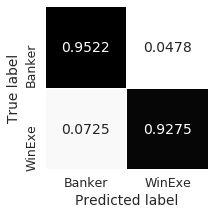

In [14]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.4f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
for h in history:
    print(h.history)

{'val_acc': [0.7407878020818534, 0.9123252858958069, 0.7623888188274873, 0.6607369758576874, 0.9377382465057179, 0.9326556543837357, 0.6874205848010402, 0.7801778907242694, 0.8958068621809934, 0.8729351974806004, 0.9212198226394314, 0.8475222363405337, 0.8767471411934045, 0.8767471408147218, 0.9288437108224047, 0.9364675995355337, 0.9186785265784403, 0.9148665824869536, 0.7357052101870807, 0.8945362136203422, 0.6416772554002541, 0.5895806861499364, 0.8386277004300109, 0.9174078781692622, 0.9224904701397713, 0.928843710292249, 0.9250317672610737, 0.936467599005378, 0.9313850068833959, 0.940279542566709, 0.9453621346886912, 0.9529860234018203, 0.9555273189326556, 0.9364675984752223, 0.9313850074135515, 0.9377382470358736, 0.9161372292299282, 0.9351969509748825, 0.9110546389256227, 0.9313850074135515, 0.9440914866581956, 0.914866582108271, 0.9491740787801779, 0.9250317662007624, 0.9466327827191868, 0.9440914871883513, 0.936467599005378, 0.9453621346886912, 0.9326556549138914, 0.8437102922

In [16]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

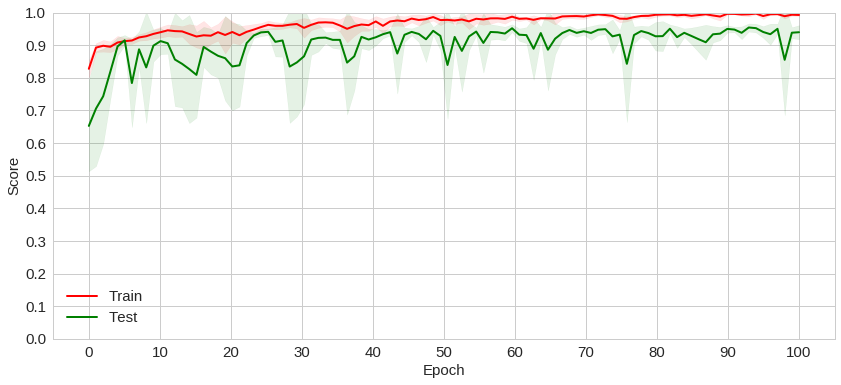

In [17]:
plot_mean_acc(history)

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

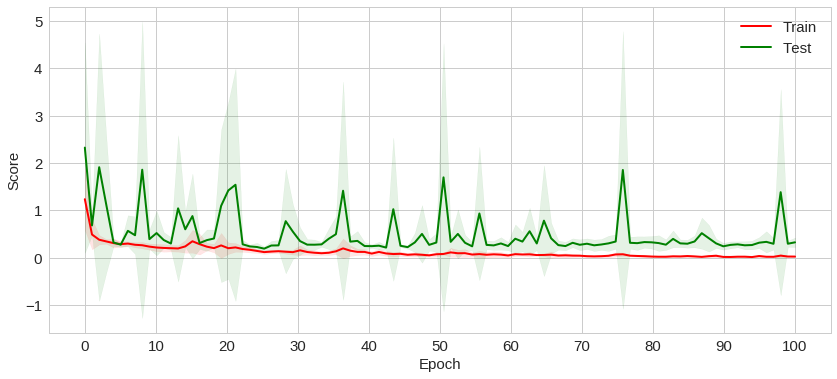

In [19]:
plot_mean_loss(history)

In [21]:
hist = [{'val_acc': [0.7407878020818534, 0.9123252858958069, 0.7623888188274873, 0.6607369758576874, 0.9377382465057179, 0.9326556543837357, 0.6874205848010402, 0.7801778907242694, 0.8958068621809934, 0.8729351974806004, 0.9212198226394314, 0.8475222363405337, 0.8767471411934045, 0.8767471408147218, 0.9288437108224047, 0.9364675995355337, 0.9186785265784403, 0.9148665824869536, 0.7357052101870807, 0.8945362136203422, 0.6416772554002541, 0.5895806861499364, 0.8386277004300109, 0.9174078781692622, 0.9224904701397713, 0.928843710292249, 0.9250317672610737, 0.936467599005378, 0.9313850068833959, 0.940279542566709, 0.9453621346886912, 0.9529860234018203, 0.9555273189326556, 0.9364675984752223, 0.9313850074135515, 0.9377382470358736, 0.9161372292299282, 0.9351969509748825, 0.9110546389256227, 0.9313850074135515, 0.9440914866581956, 0.914866582108271, 0.9491740787801779, 0.9250317662007624, 0.9466327827191868, 0.9440914871883513, 0.936467599005378, 0.9453621346886912, 0.9326556549138914, 0.843710292249047, 0.9174078790781004, 0.9275730633220648, 0.9415501911273603, 0.9275730627919092, 0.9263024142312579, 0.9301143583227446, 0.9428208386277002, 0.9351969509748825, 0.9415501911273603, 0.9453621352188469, 0.9313850068833959, 0.9250317672610737, 0.8627700127064803, 0.9174078780177891, 0.936467599005378, 0.9199491740787802, 0.9135959349866137, 0.9390088945362135, 0.9288437108224047, 0.9440914866581956, 0.9377382465057179, 0.9301143583227446, 0.9390088950663691, 0.9301143588529003, 0.9351969509748825, 0.8576874207359712, 0.9275730622617535, 0.922490470669927, 0.9390088945362135, 0.9428208391578558, 0.9351969515050381, 0.9440914871883513, 0.9377382475660293, 0.9428208396880114, 0.941550191657516, 0.9453621352188469, 0.8678526053586182, 0.8983481580905115, 0.9059720468036404, 0.9440914866581956, 0.9364675984752223, 0.9059720457433291, 0.9351969515050381, 0.9351969504447268, 0.9326556543837357, 0.9313850063532402, 0.9275730622617535, 0.517153748421157, 0.9224904701397713, 0.9135959339263025], 'val_loss': [1.3344170309536945, 0.4831331069551626, 0.7193848554617719, 3.942384316777666, 0.21916142174219086, 0.20111867136013098, 1.1766871182103624, 1.257394996410759, 0.2959449787682166, 0.6068827415682764, 0.5068814960371092, 0.6128253125771407, 0.3051990467529588, 0.3044166458910272, 0.3172701035201398, 0.21029988562231444, 0.2771668237843462, 0.24052043809180337, 0.7543620882600811, 0.43366445465607445, 5.027712529314526, 6.440247042963738, 0.41691451045427724, 0.24108238156596162, 0.38536945087634017, 0.22114070212371467, 0.3380675138728137, 0.2774489455900168, 0.23291302785712853, 0.22063735254307715, 0.21461062734115874, 0.22265779969650482, 0.2243185177258437, 0.2409136624062455, 0.27827386127304393, 0.2837620082168143, 0.38059570690441824, 0.3029456419569678, 0.47809840586116914, 0.25140343964327094, 0.2150542562806167, 0.3902664802462014, 0.2323256444707844, 0.363148594957929, 0.21320866050702794, 0.22923616810288786, 0.2755981748959161, 0.2552078428998911, 0.40013405747650715, 0.6602858575214804, 0.3891168350715952, 0.3069133142996319, 0.26815213259247994, 0.4550795838440351, 0.35262290653423556, 0.4035507843485327, 0.3098436237278535, 0.3281708403657341, 0.28657731482950827, 0.28651926521415405, 0.3292741620063479, 0.3924190599324591, 0.8189789443519416, 0.402430047230201, 0.2590549434268944, 0.3812372409768185, 0.3685278764333022, 0.33270591480617223, 0.46225683053948335, 0.30514192657445804, 0.4607816569559191, 0.4369326331658618, 0.369522553070067, 0.3987179532827007, 0.5001746445439822, 0.9505489259163034, 0.4649158045548941, 0.46800081501962654, 0.38085374613961126, 0.29460610642323914, 0.3141131478913834, 0.31576347620086803, 0.33097865751437405, 0.38139587560040805, 0.34557465911136404, 0.3184792541726013, 0.7881936432996095, 0.9509635377010234, 0.46826452633609766, 0.32180841119186016, 0.3119092778441185, 0.35651205002485264, 0.3384483428819879, 0.3216193117759885, 0.3601932721487643, 0.3540013529439581, 0.448102655810499, 5.73061532289585, 0.35787934674544136, 0.4029328781761421], 'acc': [0.8645038167938931, 0.910941475826972, 0.9198473282442748, 0.8880407124681934, 0.9277989821882952, 0.9274809160305344, 0.9347964376590331, 0.9338422391857506, 0.950381679389313, 0.9618320610687023, 0.9678753180661578, 0.977735368956743, 0.9767811704834606, 0.9704198473282443, 0.9818702290076335, 0.9767811704834606, 0.9875954198473282, 0.958969465648855, 0.9790076335877863, 0.9866412213740458, 0.9745547073791349, 0.8985368956743003, 0.92970737913486, 0.950381679389313, 0.9551526717557252, 0.9707379134860051, 0.9538804071246819, 0.9764631043256997, 0.9713740458015268, 0.9770992366412213, 0.9850508905852418, 0.9901399491094147, 0.9939567430025446, 0.9930025445292621, 0.9904580152671756, 0.9790076335877863, 0.9875954198473282, 0.9879134860050891, 0.9853689567430025, 0.9844147582697201, 0.9888676844783715, 0.977735368956743, 0.9872773536895675, 0.9923664122137404, 0.9796437659033079, 0.9942748091603053, 0.9952290076335878, 0.9968193384223919, 0.996501272264631, 0.9541984732824428, 0.986323155216285, 0.9812340966921119, 0.9901399491094147, 0.9910941475826972, 0.9955470737913485, 0.9936386768447837, 0.9914122137404581, 0.9936386768447837, 0.9952290076335878, 0.9958651399491094, 0.9926844783715013, 0.9844147582697201, 0.9930025445292621, 0.9821882951653944, 0.9812340966921119, 0.9910941475826972, 0.9949109414758269, 0.9958651399491094, 0.9993638676844784, 0.9980916030534351, 0.9974554707379135, 0.9977735368956743, 0.9990458015267175, 0.9949109414758269, 0.9885496183206107, 0.9790076335877863, 0.9888676844783715, 0.9945928753180662, 0.9961832061068703, 0.9974554707379135, 0.9987277353689568, 1.0, 0.9996819338422391, 1.0, 1.0, 1.0, 0.9949109414758269, 0.9882315521628499, 0.9688295165394402, 0.9936386768447837, 0.9958651399491094, 0.9891857506361323, 0.996501272264631, 0.9958651399491094, 0.9977735368956743, 0.9952290076335878, 0.996501272264631, 0.9786895674300254, 0.9875954198473282, 0.9923664122137404], 'loss': [0.6469598361705703, 0.24703757104679525, 0.2925080653403248, 0.34682721828534707, 0.22058270886805828, 0.1933366435629721, 0.21625665499433003, 0.22145311608341814, 0.14732519797885996, 0.11837714272563088, 0.09071013667684702, 0.07121923789334586, 0.08173269555493999, 0.08162253800988122, 0.05590403441496136, 0.06690359016958596, 0.03572946016228836, 0.11896418193331505, 0.07378736264652955, 0.03769385393912745, 0.08741311606199838, 0.3510290697482403, 0.22350930705969874, 0.15337985448785713, 0.14794367307242545, 0.09134796335013541, 0.12851191728918532, 0.08308563303230827, 0.08216926502893293, 0.060736476505025935, 0.04236099182843745, 0.026966504278088003, 0.016360656440429243, 0.024652594843049623, 0.030788607999052066, 0.08013565914732648, 0.04251813531135512, 0.04133815073340648, 0.046159137359704186, 0.05268151377050476, 0.03383765340623927, 0.07130056311691574, 0.04267350638121765, 0.02424071499314775, 0.05833830529321506, 0.0193831870739962, 0.01730000939770867, 0.007922704174338381, 0.010612386110572426, 0.1503225252554816, 0.04754255188311481, 0.07367349171515734, 0.028882712480652384, 0.029023944372262543, 0.020795498951960298, 0.015338780059027142, 0.021813048320425035, 0.020032017034020525, 0.011860236133929844, 0.013476963296269585, 0.022576270785843882, 0.04325669008717723, 0.02056112890792347, 0.05178685703965937, 0.05514492167683636, 0.02664127526101277, 0.01564570851797302, 0.010941032318816919, 0.004811315600133475, 0.006179556584988546, 0.009652209489439845, 0.007124715289634945, 0.0033921633913018747, 0.019214671777450447, 0.03821513735248296, 0.06631350584100676, 0.034532928613900817, 0.01815243531322702, 0.011338106155537398, 0.00652358099919982, 0.00349396389083036, 0.0007718484547239066, 0.0010470179990144286, 0.0011648833306211201, 0.0004995110540260845, 0.000470213596936076, 0.011989367054830436, 0.035294972500506415, 0.10016744405993334, 0.021364175429003464, 0.011817755769431986, 0.03376976486244215, 0.010730044890426777, 0.01414590117540246, 0.0076070054312122265, 0.014221957273622524, 0.010149702416848731, 0.0983625719935157, 0.03972183376989528, 0.020678145955370042]},
{'val_acc': [0.8473282451848038, 0.7989821887501627, 0.8918575072713177, 0.8167938946464286, 0.8676844798881589, 0.913486005999053, 0.5801526717557252, 0.9109414773436296, 0.9007633596886205, 0.9096692127125864, 0.9122137413680098, 0.9096692105892658, 0.5750636132315522, 0.9198473297609324, 0.8600508908885732, 0.8944020371400673, 0.9160305352611396, 0.9071246834504999, 0.9160305358678027, 0.9147582704784306, 0.9427480931197111, 0.8842239194850582, 0.8969465642788331, 0.9389312971032606, 0.9452926202584769, 0.9452926202584769, 0.8307888034645837, 0.8167938940397655, 0.8486005089058524, 0.9402035617343039, 0.9363867678411741, 0.8244274809160306, 0.8880407118615303, 0.8956742996477899, 0.9083969465648855, 0.9300254446859578, 0.9134860050890585, 0.9223918575063613, 0.955470737913486, 0.8664122137404581, 0.9491094147582697, 0.94529262086514, 0.9274809160305344, 0.9402035623409669, 0.94529262086514, 0.9478371501272265, 0.9376590330788804, 0.7798982194361795, 0.9389312971032606, 0.9618320610687023, 0.8371501266198, 0.9478371501272265, 0.9351145032101308, 0.9491094141516067, 0.9351145038167938, 0.9529262086513995, 0.9516539440203562, 0.9478371501272265, 0.9402035623409669, 0.955470737913486, 0.910941475826972, 0.8880407133781879, 0.7137404580911001, 0.9338422391857506, 0.9363867684478372, 0.9440203562340967, 0.9312977099236641, 0.9516539440203562, 0.9567430025445293, 0.9351145032101308, 0.9491094147582697, 0.9491094141516067, 0.9402035617343039, 0.9491094147582697, 0.916030534351145, 0.9249363867684478, 0.950381679389313, 0.9491094147582697, 0.9491094147582697, 0.94529262086514, 0.8409669214229244, 0.9440203562340967, 0.9402035623409669, 0.9402035623409669, 0.9236641221374046, 0.9045801528234215, 0.950381679389313, 0.9580152671755725, 0.9618320610687023, 0.9592875318066157, 0.9465648854961832, 0.9478371501272265, 0.9580152671755725, 0.9529262086513995, 0.916030534351145, 0.9389312977099237, 0.9567430025445293, 0.9465648848895202, 0.950381679389313, 0.950381679389313], 'val_loss': [2.2170084262925553, 0.7888419107503184, 0.2754280947850254, 0.4742312002500505, 0.37503521830677683, 0.2485273196042039, 0.5782342498539058, 0.2507927229689581, 0.38076191594582476, 0.2569358982809324, 0.23882311582565308, 0.2626717306730401, 0.5519639584247696, 0.32454171386232206, 0.6397830588844843, 0.3639806551910918, 0.292216315979266, 0.28107916535311983, 0.22865327942462368, 0.34533089293171737, 0.26088205104072887, 0.4325216461077295, 0.3478156540722944, 0.2565940436516099, 0.19816134608428898, 0.223537722076396, 0.36607397412146625, 0.46956130247989686, 0.3387582487504901, 0.3473467391420376, 0.2584157622118336, 0.5015070969487704, 0.3784257245389863, 0.2974259129917349, 0.2861206274569679, 0.455539871775012, 0.2865511775206367, 0.3275548551923598, 0.25576518567956735, 0.36817210641009473, 0.24424985968436733, 0.2473083978599416, 0.2558215860438559, 0.2755217617100671, 0.27862584172601695, 0.25133217655531953, 0.35254451789482644, 1.705733518470797, 0.2767654625703664, 0.24347824098082596, 0.4668876766096848, 0.30299868234302896, 0.32266805393137893, 0.29425623482116914, 0.31596802788817396, 0.252535149970349, 0.3261523984053473, 0.3566344069511305, 0.3671958553249315, 0.30992224480183356, 0.9765600898571475, 0.7133775282235068, 1.4039015881302506, 0.23339593249821025, 0.2337189379406491, 0.24600718724695403, 0.3333120330268844, 0.23262436949332782, 0.2737524134957684, 0.420624878428137, 0.261795665359118, 0.29197890550234656, 0.36886052471649555, 0.2973464424230168, 0.404564964832648, 0.34991982476501404, 0.24715451530711702, 0.30454796367208176, 0.28671772483115393, 0.3082262557185061, 0.5252754660963103, 0.3277188045868494, 0.3101235287088922, 0.33098835704140234, 0.3513419386038691, 0.32404805503728734, 0.28341925525137296, 0.2714437410651893, 0.2600220584330734, 0.275511211538794, 0.32657739113656087, 0.3148975054811658, 0.29769762257200993, 0.303829937887921, 0.44197054104861727, 0.2702662375133245, 0.27698158281950075, 0.3307335944448594, 0.2867913164675909, 0.29236275551878577], 'acc': [0.8174880765011276, 0.8702702704597922, 0.8801271860284912, 0.8868044515103338, 0.9036565977742448, 0.9042925278219396, 0.9033386327693497, 0.9217806041335453, 0.9170111287758347, 0.9262321144674086, 0.9287758346581876, 0.9408585056212445, 0.9281399046294451, 0.9255961844765704, 0.9373608903399712, 0.9462639109697933, 0.9354531003485045, 0.9335453100538026, 0.9386327504164085, 0.9427662957264243, 0.9481717013023995, 0.9526232116362627, 0.9602543720380301, 0.9640699523052464, 0.9656597776140052, 0.9694753579001738, 0.9704292527821939, 0.9593004769854402, 0.9726550079491256, 0.9793322734499205, 0.9723370429252782, 0.9624801271860095, 0.9825119237073465, 0.975198728177809, 0.9767885532591415, 0.985691573926868, 0.983147853736089, 0.983783783802736, 0.9834658187599364, 0.9764705882352941, 0.9945945945945946, 0.985691573926868, 0.9879173290937997, 0.9914149445456427, 0.9942766295707473, 0.993322734499205, 0.9837837839733057, 0.9815580286168522, 0.9952305246422893, 0.9958664547089363, 0.975516693163752, 0.9920508744038156, 0.9879173290937997, 0.992368839427663, 0.9984101748807631, 0.9942766295707473, 0.9968203497615262, 0.9917329093799682, 0.9914149443561209, 0.9984101748807631, 0.9774244834963581, 0.980286168559367, 0.9516693165647206, 0.9793322734499205, 0.9895071542130366, 0.9949125596184419, 0.9965023847376788, 0.9958664546899841, 0.9980922100464377, 0.9904610492845787, 0.9949125596184419, 0.9942766295707473, 0.9965023847376788, 0.9987281399046105, 0.9949125596563464, 0.972972972972973, 0.992368839427663, 0.9958664546899841, 0.9990461049284579, 0.9990461049284579, 0.9958664546899841, 0.9955484896661367, 0.9952305246422893, 0.9987281399235627, 0.990779014497948, 0.9910969795217953, 0.9901430842607313, 0.9993640699523052, 0.9987281399046105, 0.9990461049284579, 0.9984101748807631, 0.9980922098569157, 0.9996820349761526, 0.9993640699902097, 0.9742448330683625, 0.9936406995230525, 0.9958664546899841, 0.9993640699523052, 0.9971383147853736, 0.9971383147853736], 'loss': [2.442022751207761, 1.1053347321117626, 0.41303623018279934, 0.3493326074297174, 0.30363365167630496, 0.29755210399580306, 0.295648552498681, 0.251944124018729, 0.27075885739443983, 0.25096295921099393, 0.22776200219674927, 0.1993177957110261, 0.23604684268347978, 0.22925169449921443, 0.2118165393512465, 0.18718173501092128, 0.24556940813417086, 0.24982123033799503, 0.1872082492221141, 0.16491498624956286, 0.15200718928406842, 0.12772430375289462, 0.1218803604475455, 0.10648012153792458, 0.0958200031201487, 0.08541497554043707, 0.0881354939992079, 0.11162118885210094, 0.07537856962360051, 0.05677205633715577, 0.08268945746246684, 0.10178757643042834, 0.059042435161923375, 0.0779473374705815, 0.060943455285494864, 0.045551016952676646, 0.04460057500714291, 0.04585611451127002, 0.04395434595941065, 0.06260170126426373, 0.01869599005521685, 0.041992696510281396, 0.03286432023034305, 0.021744048161897067, 0.014208571418278831, 0.016788526974760576, 0.03985103694233445, 0.050026109421978125, 0.021583890613942204, 0.012109765210907036, 0.07654645428837341, 0.023089505795208777, 0.033044548508924375, 0.034202849479401054, 0.00784080756916287, 0.020608297726457763, 0.008929375651795827, 0.02586428642302377, 0.021802594218141583, 0.005309641807131315, 0.09099635185291828, 0.07174360218749563, 0.1614240383551662, 0.060304706177669795, 0.02933534311873924, 0.014613273934481905, 0.014730266587244604, 0.012842119928099915, 0.006648553548297817, 0.026963044894622385, 0.014209218951753179, 0.01874618227062421, 0.008722350410769127, 0.004906613472857228, 0.01351663055267986, 0.10100718888280905, 0.02259082908865023, 0.013565453054569958, 0.0030491624680175247, 0.004177123134225068, 0.016893214540906244, 0.0113762475696573, 0.018262400373369337, 0.005640509333357878, 0.029310315111370694, 0.030606947512038657, 0.022121988957791914, 0.004221800931704552, 0.0029517868670018792, 0.003062521040736474, 0.006935805932122941, 0.0045275728547352805, 0.0015985817495007269, 0.0020915802960786638, 0.08248129678143866, 0.022587803225010774, 0.00991206138769745, 0.003013821741385054, 0.009311073329809584, 0.006725630408600091]},
{'val_acc': [0.494910941475827, 0.494910941475827, 0.494910941475827, 0.8536895674300254, 0.8791348600508906, 0.9312977093170011, 0.917302799133854, 0.8969465657954908, 0.9312977093170011, 0.950381679389313, 0.9516539440203562, 0.94529262086514, 0.9554707386718149, 0.5788804071246819, 0.9376590330788804, 0.891857507119652, 0.9503816801476418, 0.9529262086513995, 0.8778625955715131, 0.9465648854961832, 0.94529262086514, 0.9427480916030534, 0.9427480916030534, 0.9363867684478372, 0.955470737913486, 0.9580152671755725, 0.9592875318066157, 0.9567430025445293, 0.9592875318066157, 0.9491094141516067, 0.9465648854961832, 0.9452926202584769, 0.9643765903307888, 0.913486005999053, 0.9096692119542575, 0.8778625954198473, 0.5292620865139949, 0.6628498727735369, 0.94529262086514, 0.9529262086513995, 0.8956743002544529, 0.950381679389313, 0.9541984732824428, 0.6297709923664122, 0.9465648854961832, 0.9516539440203562, 0.9529262086513995, 0.9618320610687023, 0.9541984732824428, 0.9541984732824428, 0.9631043256997456, 0.8676844798881589, 0.9592875318066157, 0.9541984732824428, 0.9465648854961832, 0.9643765903307888, 0.9567430025445293, 0.9643765903307888, 0.955470737913486, 0.960559796437659, 0.9669211195928753, 0.9567430025445293, 0.9694656488549618, 0.9580152671755725, 0.9580152671755725, 0.9656488549618321, 0.9694656488549618, 0.9580152671755725, 0.9249363867684478, 0.9580152671755725, 0.9656488549618321, 0.9707379134860051, 0.9707379134860051, 0.9694656488549618, 0.9325699747063732, 0.9770992366412213, 0.9694656488549618, 0.9669211195928753, 0.9669211195928753, 0.9732824427480916, 0.9720101781170484, 0.9732824427480916, 0.9631043256997456, 0.9529262086513995, 0.9656488549618321, 0.960559796437659, 0.9707379134860051, 0.9656488549618321, 0.9541984732824428, 0.9669211195928753, 0.9618320610687023, 0.9656488549618321, 0.9707379134860051, 0.9707379134860051, 0.9707379134860051, 0.9720101781170484, 0.9669211195928753, 0.9669211195928753, 0.9185750643715603, 0.955470737913486], 'val_loss': [6.6241132198407895, 1.036569852410382, 7.543640164593258, 0.4828750127902771, 0.3972211715980947, 0.28018067993280543, 0.3668103014846491, 0.3540978142778382, 0.2821174533540056, 0.23445982605446386, 0.22862601830000792, 0.25993926335912926, 0.18867436074118576, 4.128691497520706, 0.3889668231057453, 0.3521837606154022, 0.15711201490412535, 0.14226044040486102, 0.3099380146911126, 0.20555925897723087, 0.19551914264436138, 0.16476974530150265, 0.1691280488521998, 0.17481728372313365, 0.11913291617763483, 0.10709738650337886, 0.10528467536095823, 0.15291812283202588, 0.1190732106301014, 0.1260803165364508, 0.14396236193278666, 0.18801187864165878, 0.16182357488903892, 0.2553003643267331, 0.7610666735178339, 1.2170049507851042, 6.020254080203503, 0.4777534114950486, 0.17222501444642174, 0.1574637610797057, 0.27371149172688863, 0.1394500102440213, 0.12138628869841193, 4.044770850669644, 0.21867628605282716, 0.1559309126144517, 0.1458520085738057, 0.1162542404142462, 0.13850103451398796, 0.14772729024186768, 0.11334361699788947, 0.42830063021355536, 0.19141567659590383, 0.1395101507547437, 0.16035398400125614, 0.11331887446277546, 0.1857699230976839, 0.11602786641494482, 0.13248813562995682, 0.1533873885900787, 0.13464766817372387, 0.1821207812401933, 0.11919065968176193, 0.20688386378767154, 0.13715619929478465, 0.11969668086370543, 0.1305447856769509, 0.18238251451071133, 0.2484055768589444, 0.14763623891687425, 0.11580605025737341, 0.12759820423394078, 0.15360697153564684, 0.13022562450286163, 0.18412990441531626, 0.09210620022470098, 0.11110644796318149, 0.12586355681306594, 0.11227686937250263, 0.09721906606164825, 0.09404024415241873, 0.11445277666497701, 0.14759103851423228, 0.19267614640807376, 0.1298451236971718, 0.1747136691978566, 0.1624787282985878, 0.1693083995394231, 0.1872003922021519, 0.1177757706474033, 0.192351202542174, 0.17291070567718897, 0.14511288385026622, 0.13410969248683424, 0.1040333797307993, 0.10400506539017604, 0.12159660745570738, 0.18985999815649432, 0.2688439231716646, 0.2835889741504072], 'acc': [0.8136724961012459, 0.9011128776403224, 0.8744038156181906, 0.873449920508744, 0.8705882352941177, 0.8998410174880763, 0.912241653607646, 0.9058823529411765, 0.9198728140662699, 0.925596184438666, 0.9268680445530078, 0.9306836248391762, 0.9338632750397456, 0.9360890303961992, 0.9195548489855658, 0.8893481717011129, 0.927821939643502, 0.9287758346771398, 0.9335453100348504, 0.9430842607313196, 0.9459459459459459, 0.9500794912654379, 0.9405405405973971, 0.9427662958969941, 0.9564387917329094, 0.9570747217806042, 0.9605723370429253, 0.9596184419713831, 0.9605723370429253, 0.9701112877583465, 0.9650238473767886, 0.9666136724960255, 0.9624801271860095, 0.9701112877583465, 0.9519872813990461, 0.9414944358016046, 0.8712241653797168, 0.9042925278219396, 0.9329093799682034, 0.9402225755166932, 0.9503974562798092, 0.9303656597774245, 0.9491255961844197, 0.951033386327504, 0.953577106518283, 0.964069952362103, 0.951033386327504, 0.966931637538825, 0.9726550079491256, 0.9707472178060413, 0.9707472178060413, 0.9701112877583465, 0.9748807631160572, 0.9767885534486634, 0.9697933227724036, 0.9726550079491256, 0.9891891892081414, 0.982193958664547, 0.9841017488076311, 0.9888712243548637, 0.9793322734499205, 0.9888712242032462, 0.9834658189494583, 0.9837837838406404, 0.9841017488076311, 0.9914149443561209, 0.9917329093989204, 0.9885532591604467, 0.978060413354531, 0.9914149443561209, 0.9958664546899841, 0.997456279809221, 0.9961844197138314, 0.9920508744606722, 0.9605723370429253, 0.9891891893787111, 0.9901430842796836, 0.9879173292833217, 0.9904610492845787, 0.9977742448330683, 0.9968203497615262, 0.9939586645848042, 0.9825119237073465, 0.9891891891891892, 0.9984101748807631, 0.9987281399046105, 0.9965023847376788, 0.9977742448330683, 0.9990461049284579, 0.9984101748807631, 0.9949125596184419, 0.9958664546899841, 0.983147853736089, 0.9926868045083669, 0.9841017488076311, 0.9952305246422893, 0.9977742450225903, 0.9914149443561209, 0.9936406995230525, 0.9863275039745628], 'loss': [0.9049318267355284, 0.3744860547146092, 0.5517721449248552, 0.42003265195696454, 0.48520035474355344, 0.37238163358409, 0.3556969975344896, 0.3748890236422822, 0.337438106612674, 0.32039345625095034, 0.31684709368525327, 0.2944355931873352, 0.27220320789430685, 0.27687763006963867, 0.29018488583200874, 0.6660007523452723, 0.25634369668217644, 0.23942405964308588, 0.20721510382449115, 0.17684597592380355, 0.1782858345793806, 0.16329377851728794, 0.19562763204066666, 0.18695345229109445, 0.15740712454960057, 0.13152182268508855, 0.14456995468118802, 0.12586173040226742, 0.11860150124267668, 0.10510755679044512, 0.13023984996751484, 0.10834854587569051, 0.12776253822308467, 0.10009929011731344, 0.16327836594303008, 0.19455848668356956, 0.6007698050364023, 0.3449524586881098, 0.1850190429825377, 0.16761189910963722, 0.14524379432769952, 0.18768332188679512, 0.1658854647333747, 0.1486602391556071, 0.14506002012314498, 0.10726906042220292, 0.1413011212914661, 0.09957649688368192, 0.08493571398462893, 0.08194523416281883, 0.09442137905495723, 0.09018828035532149, 0.08091803388958811, 0.07181653826481209, 0.09214975071067082, 0.07692219039724343, 0.03803879523824527, 0.045497779613316344, 0.045257100182184165, 0.031921626654689, 0.05410826253113951, 0.03169349284016413, 0.046025186318708715, 0.043502694398567486, 0.043388263165465124, 0.023303374120023913, 0.020825351063541133, 0.03228805842194914, 0.07338216426606115, 0.025780374070093485, 0.012328849894154538, 0.009760247132062966, 0.009439897157262199, 0.01796870395150302, 0.1351932120644184, 0.03522045813939151, 0.0293896810055395, 0.03869417803732172, 0.027420677899272702, 0.007607278551918192, 0.010700661012205475, 0.013779594224695537, 0.05216916751261617, 0.034529329130251335, 0.0070388518364889775, 0.007008858654697667, 0.008996044416659821, 0.0073100536309988855, 0.004186301481160846, 0.005281326681485071, 0.01113900945836342, 0.014793716280965943, 0.05597399610564089, 0.022591748693587765, 0.04652901631550007, 0.014673023693676629, 0.007001996551165047, 0.021005503113406737, 0.02101670352383761, 0.04194321530554236]},
{'val_acc': [0.6857506361323156, 0.494910941475827, 0.881679388706314, 0.8600508907369075, 0.8753180663094265, 0.9096692105892658, 0.8002544523195456, 0.916030533744482, 0.49236641221374045, 0.8180661580641457, 0.8371501266198, 0.9083969459582224, 0.9338422385790875, 0.9389312978615895, 0.9083969459582224, 0.7391857500294693, 0.9147582698717676, 0.879134859747559, 0.9020356228030062, 0.9427480909963903, 0.9414758284886678, 0.8905852414269484, 0.9389312978615895, 0.9274809163338659, 0.9440203556274337, 0.937659034595538, 0.8969465645821647, 0.9274809169405289, 0.49745547073791346, 0.5190839697689804, 0.5725190833628025, 0.9351145039684596, 0.8587786274708561, 0.9312977114403217, 0.8791348603542221, 0.8893129775542339, 0.932569976071365, 0.8664122138921238, 0.8638676844783715, 0.8944020350167466, 0.9414758263653471, 0.9300254462026154, 0.937659033988875, 0.9312977093170011, 0.932569976071365, 0.9402035638576246, 0.888040713984851, 0.9389312986199182, 0.9338422407024083, 0.9312977114403217, 0.5216284987277354, 0.9249363869201136, 0.633587785652879, 0.8447837144060596, 0.9402035632509615, 0.7264631037190367, 0.8944020359267412, 0.9020356235613349, 0.8956743004061187, 0.9325699739480443, 0.9198473276376118, 0.9338422385790875, 0.9452926210168057, 0.917302799133854, 0.6374045802664211, 0.8282442742024972, 0.9325699739480443, 0.9262086515511568, 0.9325699739480443, 0.9274809154238713, 0.9351145032101308, 0.9287531800549146, 0.9325699739480443, 0.8269720110881116, 0.9236641215307415, 0.494910941475827, 0.9109414759786377, 0.9274809161822001, 0.9262086523094857, 0.9312977093170011, 0.9325699747063732, 0.9363867678411741, 0.9198473276376118, 0.9134860044823955, 0.9236641215307415, 0.9338422385790875, 0.9300254446859578, 0.926208650792828, 0.9325699739480443, 0.9351145032101308, 0.9440203556274337, 0.9325699739480443, 0.9465648870128408, 0.9402035638576246, 0.9402035617343039, 0.8753180670677554, 0.9363867678411741, 0.9058524166961359, 0.9376590324722174, 0.9147582691134387], 'val_loss': [0.5602717138732056, 0.6034300653382415, 0.32027703277179, 0.34740017312780286, 0.3574435863899821, 0.32774154731942196, 0.47374542046139256, 0.26968483418302075, 8.117587333743003, 0.6622349075752645, 1.4291622662116548, 0.5194073352422423, 0.2017574700462909, 0.19702370825007975, 0.3328188307246824, 0.8312288562437808, 0.2663103180721819, 0.37759002171096606, 0.2788075124679024, 0.1657548895622331, 0.16869750770600395, 0.27506266521057704, 0.22499698029390272, 0.2875516733140436, 0.18782057429239646, 0.19481047860917852, 0.2666217458005473, 0.19403677412875128, 2.966684233988579, 1.6842932525178556, 0.9191918093948116, 0.2170728936450172, 0.4193634214898709, 0.36658745556690614, 0.5117758168594831, 0.35984314172398346, 0.21010520879852257, 0.4171085375865907, 0.6957160475576158, 0.2851470778613297, 0.18299032175207258, 0.25266064438049424, 0.22210543350560671, 0.28135864997789756, 0.27567781752944653, 0.24508785719938253, 0.6852623254591576, 0.30307013931999377, 0.3968548213555916, 0.3981781664799719, 7.346151081537686, 0.48320779357930177, 1.5259068913511344, 0.5404519659796441, 0.23475765298492732, 3.7426326841722686, 0.3775403610888025, 0.30607486876443446, 0.5057591359882257, 0.34012565039496384, 0.3586730702991097, 0.25038707840230323, 0.29555569693408246, 0.5141639239178454, 3.1190293827129683, 1.041164993155634, 0.31608932330711503, 0.34736742682129373, 0.36995566604094954, 0.3453118289244994, 0.3316845521638905, 0.31308042301628125, 0.3665362099806468, 0.5428541659095512, 0.4683283810852138, 7.683262516478131, 0.4140298571674575, 0.45794533398067555, 0.45146073332250725, 0.43418466546584594, 0.439338826048887, 0.4217681418109031, 0.5223015913687665, 0.37777948635215597, 0.3411614563429856, 0.318485582763988, 0.3227374731603318, 0.3753049336018339, 0.33693365411686005, 0.26478145668714403, 0.33700755976955704, 0.28903535046346923, 0.3401896288717976, 0.37768322561628187, 0.36823270377008666, 0.7453850442100959, 0.40128253025900923, 0.4565319674961629, 0.3574151919239957, 0.4561381818153173], 'acc': [0.8508744038345325, 0.8934817170490331, 0.9077901432737826, 0.9103338633129441, 0.9189189189947277, 0.9176470588614338, 0.9141494435612083, 0.9297297297297298, 0.9208267090620031, 0.9246422895376937, 0.9268680445151033, 0.9281399046483972, 0.9281399046294451, 0.9313195548489667, 0.944356121016231, 0.9319554848966614, 0.9494435612082671, 0.9424483306836248, 0.9497615262510667, 0.9624801272428661, 0.9564387919224313, 0.9580286168521462, 0.9659777424483307, 0.9647058825424631, 0.9685214626391097, 0.975516693163752, 0.9717011130671054, 0.9529411764895405, 0.9596184419713831, 0.9558028617041668, 0.8988871224165342, 0.9421303656597774, 0.9577106518472511, 0.9602543720190779, 0.9685214626391097, 0.9405405405405406, 0.9545310015898251, 0.954531001779347, 0.9577106518662033, 0.9446740858505565, 0.9647058823908455, 0.9685214626580619, 0.9774244833257885, 0.9790143084450253, 0.9812400637825267, 0.9837837837837838, 0.9920508744038156, 0.985691573926868, 0.9942766295707473, 0.9939586645468999, 0.980286168559367, 0.9589825119236884, 0.9647058825424631, 0.9268680445340556, 0.9615262321144674, 0.9507154213226088, 0.9507154213036566, 0.963434022295456, 0.953577106518283, 0.9710651828488409, 0.9723370429442304, 0.9783783783783784, 0.9853736090925426, 0.9815580286358043, 0.9707472178060413, 0.9459459459459459, 0.978060413354531, 0.9799682034976153, 0.9847376788553259, 0.9853736089030206, 0.9844197138314785, 0.9926868044515104, 0.9879173290937997, 0.9825119236883942, 0.9799682034976153, 0.9726550079491256, 0.9771065182829889, 0.9837837837837838, 0.9732909380347248, 0.9818759936406996, 0.9901430842607313, 0.9885532591793988, 0.9910969795217953, 0.9898251192937405, 0.9812400636309092, 0.9834658187599364, 0.9971383147853736, 0.9961844197896402, 0.9783783783783784, 0.997456279809221, 0.9961844197138314, 0.9961844197138314, 0.9987281399046105, 0.9990461049284579, 0.9980922098758679, 0.9939586645468999, 0.9952305246612415, 0.983783783802736, 0.9942766295896994, 0.993322734499205], 'loss': [0.7959580687631295, 0.34142288920041675, 0.3093247346734015, 0.2923364804071539, 0.2585032013338207, 0.25785659155519663, 0.3081932605023604, 0.2632045474572667, 0.311580709662934, 0.24932657091956828, 0.24664628638490585, 0.2694329881705995, 0.2395580320365857, 0.2069908615870961, 0.16397733578905582, 0.20113061769541193, 0.1805070822942996, 0.1857724040154433, 0.1715917713596635, 0.12598564956923547, 0.13387772876810763, 0.13430316723455246, 0.10017704055163364, 0.10820024641310656, 0.09143012811582304, 0.07713141209006884, 0.08773336671115105, 0.18311078607183193, 0.17526508665840557, 0.17521824202780126, 0.3437086852607932, 0.19452773351311115, 0.1613119469917067, 0.11782983176658945, 0.12109691592108085, 0.197986583010144, 0.1464815447346821, 0.17762999828365914, 0.19895034956439311, 0.19748074555434939, 0.11249084094560013, 0.10068353913215082, 0.0708461857325322, 0.06126174597818825, 0.05661362961455824, 0.0614083521926127, 0.03475078465979671, 0.042115602177645144, 0.034842014758564854, 0.021874426283868712, 0.0783419768780541, 0.28933821610968696, 0.23384485413366263, 0.2542801805255144, 0.1288006615349712, 0.1982101105970874, 0.16801395816920955, 0.1893567286206732, 0.16489756712912093, 0.11564009761251214, 0.13750062863000437, 0.10995098167056121, 0.04401168740800151, 0.06067539267774985, 0.10256795309401089, 0.18864259275715853, 0.09697662939884609, 0.13429711887624785, 0.07235076512959275, 0.06206000714380715, 0.061249110300170884, 0.05491712051080999, 0.06973087882971211, 0.08458935844908884, 0.093555410930647, 0.11640406314621195, 0.06362092568744893, 0.05700048710255098, 0.07643758962567546, 0.05827988151976149, 0.02803317549947904, 0.04694944303838124, 0.032171802984666084, 0.0301598917325701, 0.061376534056492946, 0.046633859026721056, 0.010181947454028364, 0.015392745444876852, 0.054358642746987554, 0.013465359572703181, 0.014280685111059472, 0.009764482235130052, 0.004602224399868343, 0.0025165196801785585, 0.005538868871993135, 0.020695640861104127, 0.017373498426106224, 0.05135212192394799, 0.019637410494236836, 0.01767189918405751]},
{'val_acc': [0.494910941475827, 0.8282442752641576, 0.6870229007633588, 0.9045801534300846, 0.921119592268655, 0.8893129764925736, 0.9351145038167938, 0.9338422391857506, 0.9402035623409669, 0.9427480916030534, 0.9414758263653471, 0.9198473297609324, 0.9402035632509615, 0.9007633584752944, 0.5, 0.583969466255518, 0.774809161215338, 0.7493638688978045, 0.9071246813271792, 0.6030534351524203, 0.7035623409669212, 0.8854961832061069, 0.916030534351145, 0.9300254452926209, 0.9300254452926209, 0.9363867684478372, 0.9402035623409669, 0.9363867684478372, 0.9363867684478372, 0.8880407124681934, 0.9300254452926209, 0.9300254452926209, 0.9465648854961832, 0.9402035623409669, 0.9541984732824428, 0.9478371501272265, 0.9427480916030534, 0.9440203562340967, 0.9529262086513995, 0.9427480916030534, 0.8918575072713177, 0.9287531814199064, 0.9325699753130362, 0.9465648854961832, 0.8893129770992366, 0.9211195936336469, 0.9580152671755725, 0.9656488549618321, 0.9618320610687023, 0.9529262086513995, 0.9580152671755725, 0.9592875325649446, 0.9440203562340967, 0.9592875318066157, 0.9618320610687023, 0.9618320610687023, 0.9580152671755725, 0.9491094147582697, 0.9465648854961832, 0.9669211195928753, 0.9325699753130362, 0.9516539440203562, 0.955470737913486, 0.960559796437659, 0.9631043256997456, 0.942748092513048, 0.9402035617343039, 0.9592875318066157, 0.9465648870128408, 0.950381679389313, 0.9007633602952836, 0.9592875325649446, 0.9643765903307888, 0.960559796437659, 0.955470737913486, 0.960559796437659, 0.8982188295165394, 0.9516539434136931, 0.9058524166961359, 0.8447837153160541, 0.9592875325649446, 0.955470737913486, 0.86386768417504, 0.9414758269720102, 0.8880407132265222, 0.8486005096641812, 0.8269720116947746, 0.9198473282442748, 0.9236641215307415, 0.94529262086514, 0.9516539440203562, 0.9389312984682525, 0.9618320610687023, 0.9631043256997456, 0.9440203562340967, 0.951653944778685, 0.9643765903307888, 0.9402035632509615, 0.9631043256997456, 0.9656488549618321], 'val_loss': [0.874263149863891, 0.47784766046752153, 0.683089798918283, 0.285498397457994, 0.23403709414047746, 0.2981940908286408, 0.2220977556159478, 0.21946845498438403, 0.19698096385211436, 0.17976629469572133, 0.17940760511933393, 0.19107792357755374, 0.2268183389844482, 0.23992425995776975, 1.302005027845009, 2.6193887307747024, 0.535490270789343, 0.7915840434057415, 0.43564789399087583, 4.306374971344877, 1.4297222359338182, 0.37119074874858515, 0.23436561613592483, 0.21360524131444877, 0.2192285813429125, 0.190406249945097, 0.19224679990465404, 0.18722813187816367, 0.1829239476007663, 0.35298030982718215, 0.19627586930383556, 0.22952501747861467, 0.16835413682665534, 0.22710147717820703, 0.1425266177713416, 0.14710440288556137, 0.15843990674057534, 0.15184021044437213, 0.15468876775704873, 0.1504107627249856, 0.2851051014798288, 0.21993928328725218, 0.21604385706607926, 0.14063243264612046, 0.25461426648399, 0.2145893914440206, 0.1344225195831318, 0.11365758800172927, 0.12393527796003806, 0.13291748879008167, 0.15148811012923566, 0.13351869530046867, 0.18408815004523968, 0.12621309618648074, 0.11631666005852113, 0.14112551860113182, 0.13295384943864424, 0.1730465251672776, 0.19408181077935768, 0.1189465947335458, 0.18618833760875478, 0.14311785606368807, 0.13625102652753432, 0.12666268095210592, 0.14470103059589634, 0.2391573817827016, 0.1616139566246183, 0.11323491061276948, 0.20047073703230792, 0.12592320604861237, 0.28755354564684343, 0.11870196766904899, 0.11607374202930451, 0.12537605792483072, 0.13002407913624708, 0.17140789092020736, 0.3182000217878712, 0.16026424752126517, 0.3991720474706655, 0.4718377649092113, 0.15158323495253048, 0.17367899028893025, 0.6573251813991379, 0.21343845614817458, 0.28878325239089303, 0.5593689663985, 1.014424168426572, 0.2622475943246112, 0.23951216608892567, 0.2044623376630986, 0.16479756963929829, 0.257996566240402, 0.16802824909251382, 0.18086562022026487, 0.29195101783476396, 0.1805306986761078, 0.201443854542852, 0.19367057536242877, 0.18616474723311865, 0.16938752582908131], 'acc': [0.7926868044704626, 0.8883942766864273, 0.9100158982511923, 0.9179650240368987, 0.9208267090620031, 0.9141494435612083, 0.9081081081081082, 0.9284578698238621, 0.9303656597774245, 0.9354531001589825, 0.9497615264216364, 0.9513513513703036, 0.9500794912559618, 0.9491255961844197, 0.8896661367818168, 0.8896661367628647, 0.8524642289348172, 0.8826709063898399, 0.8992050874403815, 0.8225755167500203, 0.8782193960559767, 0.8941176470588236, 0.9093799682034976, 0.9182829888901763, 0.9332273449920508, 0.9402225755166932, 0.9414944358016046, 0.9500794914454838, 0.9507154214931786, 0.9434022257741191, 0.9456279809220985, 0.9516693163941509, 0.9513513513703036, 0.9532591414944356, 0.9577106518662033, 0.9564387917518615, 0.9554848966613673, 0.9631160572716086, 0.958664547089363, 0.9621621621621622, 0.9662957074911303, 0.9357710653723518, 0.9634340222575517, 0.965977742486235, 0.9593004769475357, 0.9732909380157725, 0.9650238474336451, 0.968839427662957, 0.9739268680445151, 0.9713831478537361, 0.9761526232114467, 0.9774244833068363, 0.9774244834963581, 0.9790143084260732, 0.9809220985691574, 0.9841017488076311, 0.9841017488076311, 0.9818759938302214, 0.9796502384737679, 0.9837837837837838, 0.9834658187599364, 0.9783783783783784, 0.9761526232114467, 0.9869634340222575, 0.9866454689984102, 0.9866454689984102, 0.9806041335642622, 0.9853736089219729, 0.9869634340412098, 0.975516693163752, 0.9872813990461049, 0.9901430844502532, 0.9837837839733057, 0.982193958664547, 0.9841017488076311, 0.9917329093799682, 0.9834658187599364, 0.9869634340222575, 0.9920508744038156, 0.9907790143084261, 0.989825119236884, 0.9955484896661367, 0.9907790143084261, 0.9888712243548637, 0.9802861685214627, 0.9891891891891892, 0.9961844197706881, 0.9748807631160572, 0.9949125596184419, 0.993322734499205, 0.9952305246422893, 0.9920508744038156, 0.9965023847376788, 0.9984101748807631, 0.9936406995230525, 0.9965023847376788, 0.9920508745933375, 0.992368839427663, 0.9952305246422893, 0.9952305246422893], 'loss': [1.3687631706933718, 0.36125380716187394, 0.3116850254787739, 0.28982771598098767, 0.25362124079172105, 0.2924377556919862, 0.296409769727003, 0.23412323518758357, 0.22926421939663363, 0.21275014322020103, 0.17423874307986473, 0.1754431866287048, 0.15590522405743268, 0.160365280208129, 0.4521045032859038, 0.595402483113809, 0.689422316426361, 0.3540565926433557, 0.35050691041876286, 0.7734199880226996, 0.4299988457811656, 0.28936749512895305, 0.25597163661485256, 0.2600533079077595, 0.20152024301346422, 0.18413376531227593, 0.17633630198401373, 0.16270715203402722, 0.16079468584970374, 0.1698360535222889, 0.1603695083948501, 0.14965364805560422, 0.1396756619451914, 0.13246942741769724, 0.12454894151899887, 0.13607366704789178, 0.12828203289871754, 0.1134392384315333, 0.11873235484090633, 0.11073434339845124, 0.10681616137061854, 0.18760396145485542, 0.11516635653656124, 0.10982562637101675, 0.11766257407721162, 0.08316720220451325, 0.10060963486639608, 0.08960079361813436, 0.07733382465397799, 0.07820810367588682, 0.07949656384548436, 0.06495972703579689, 0.0718773207528034, 0.06956875403670798, 0.062339525346441375, 0.05003312104314992, 0.05353817808721659, 0.057504062726501444, 0.061345155062250176, 0.050081387549543985, 0.04989351171404952, 0.06319298271344462, 0.06513419525808135, 0.041807630718559835, 0.04023545210165325, 0.04785560459943876, 0.06285150781250151, 0.04421704339725224, 0.043615308762875955, 0.07234547437836426, 0.04216775554565443, 0.031042118061375353, 0.049262181264370535, 0.05492989701140799, 0.04184923512633114, 0.02243618537251362, 0.04453404275507967, 0.03566164431293215, 0.02290466267005533, 0.02687579427574819, 0.02460995899685118, 0.011249123753266133, 0.023241456832664733, 0.04329969471021421, 0.057182874478435286, 0.03253500701264376, 0.013798951554824324, 0.07971553208605521, 0.02248447610950764, 0.020976633383973542, 0.012240369480165441, 0.022794951726619557, 0.014061842188209484, 0.006229271060570227, 0.015799573942248193, 0.008563169009819929, 0.03153674154437261, 0.023948238736658176, 0.015300442511567458, 0.012434225989087737]}]

In [22]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc'])))

[0] Epoch: 32 - Max val_acc: 0.9555
[1] Epoch: 49 - Max val_acc: 0.9618
[2] Epoch: 75 - Max val_acc: 0.9771
[3] Epoch: 92 - Max val_acc: 0.9466
[4] Epoch: 59 - Max val_acc: 0.9669


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

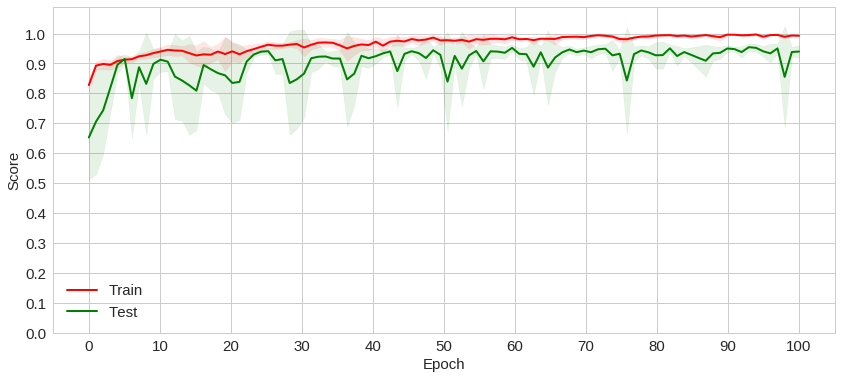

In [24]:
plot_mean_acc(hist)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

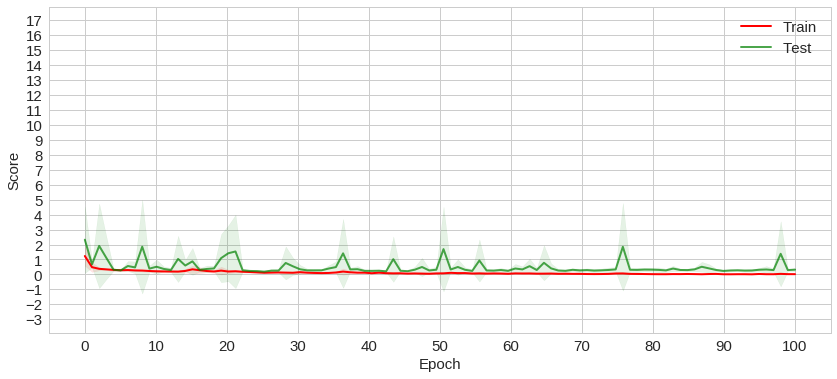

In [26]:
plot_mean_loss(hist)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean), np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean), np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-5, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

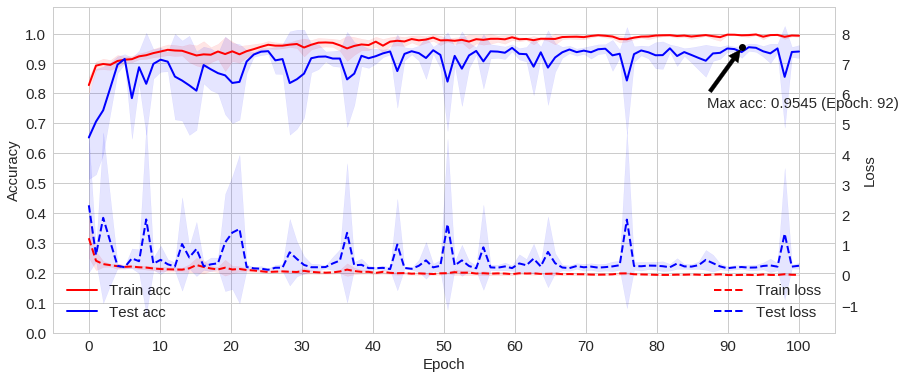

In [28]:
plot_mean(hist)